In [1]:
from jax_circuits import *
from scipy.stats import unitary_group
import matplotlib.pyplot as plt

import time

from qiskit import transpile
from qiskit.quantum_info import Operator

from topology import *

from jax import custom_jvp, jvp, grad
from jax.scipy.optimize import minimize

key = random.PRNGKey(0)

# Gradient descent vs Staircase

Test circuit.

In [7]:
# Unpack layer for better resemblamce of random circuits.
layers_dict =  fill_layers(sequ_layer(3), 14)
p_periodic, n  = layers_dict['layers']
p_free = layers_dict['free']


a = Ansatz(3, 'cz', {'free':p_periodic*n+p_free})
u_target = a.unitary(jnp.array(range(a.n_angles), dtype='float32'))
    
key, subkey = random.split(key)    
initial_angles  = random.uniform(random.PRNGKey(0), shape=(a.n_angles, ), minval=0, maxval=2*jnp.pi)

Timing a single update step.

In [3]:
opt = optax.adam(0.01)
opt_state = opt.init(initial_angles)
def discr(angles):
    return disc2(a.unitary(angles), u_target)
                 
loss_and_grad = value_and_grad(discr)

def angles_gd():
    return gradient_descent_update(loss_and_grad, opt, opt_state, initial_angles)

def angles_sc():
    return staircase_update(discr, initial_angles)

# To exclude compilation time
_ = angles_gd()
_ = angles_sc()

In [4]:
%timeit angles_gd()
%timeit angles_sc()

60.5 µs ± 856 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
2.25 ms ± 49.4 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


Timing full learning cycle.

In [8]:
%%time
angles_history_gd, loss_history_gd = gradient_descent_learn(a.unitary, u_target, a.n_angles, 
                                                            initial_angles=initial_angles, 
                                                            n_iterations=5000)

CPU times: user 19.1 s, sys: 345 ms, total: 19.5 s
Wall time: 18.4 s


In [9]:
%%time
angles_history_sc, loss_history_sc = staircase_learn(a.unitary, u_target, a.n_angles,
                                                     initial_angles=initial_angles, 
                                                     n_iterations=5000, 
                                                     keep_history=True)

CPU times: user 42.2 s, sys: 146 ms, total: 42.3 s
Wall time: 41.5 s


Here is an additional learning method, which starts with SC updates and finishes with GD updates. Perhaps the runtime here can be increased significantly if we do not jit-compile SC iterations.

In [10]:
%%time
angles_history_hd, loss_history_hd = hybrid_learn(a.unitary, u_target, a.n_angles,
                                                     initial_angles=initial_angles, 
                                                     n_stairs = 10,
                                                     n_iterations=5000, 
                                                     keep_history=True)

CPU times: user 38.9 s, sys: 382 ms, total: 39.3 s
Wall time: 37.9 s


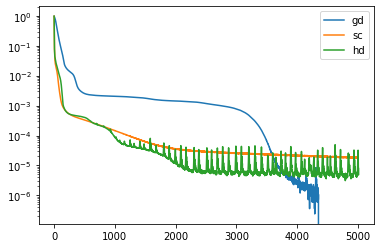

In [11]:
plt.plot(loss_history_gd, label='gd')
plt.plot(loss_history_sc, label='sc')
plt.plot(loss_history_hd, label='hd')
plt.legend()         
plt.yscale('log')

Implications: staricase (SC) seems to converge much faster initially, but much slower to reach very high fidelity. Learning runtime is better for gradient descent (GD) due to much faster single update step. With GD all angles are updated simultaneously while SC updates them one by one. Updating all angles within a single SC step seems to ruin the convergence. A good option might be to update them in batches. That would speed up the learning. Also note that GD and SC generally converge to different local minimums. GD seems to usually find better local minimum than SC but perhaps this is bad statistics on my side.